In [2]:
notebook_mode = True
viz_mode = False

In [3]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. GPU cannot be used.")


CUDA is not available. GPU cannot be used.


# Import packages

In [4]:
import os
import json
import argparse
import time
import random

import numpy as np
import csv

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter  # tensorboardXの代替

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore")
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.exact_solution import SolveExactSolution
from utils.beamsearch_uelb import *
from utils.flow import Flow
from utils.data_maker import DataMaker
from utils.dataset_reader import DatasetReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *
from utils.create_data_files import *

# Setting for notebook

In [5]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

# Load configurations

In [6]:
config_path = "configs/default2.json"

config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default2.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'graph_filepath': './data/graph.gml', 'edge_numbering_filepath': './data/edge_numbering_file.csv', 'train_filepath': './data/gragh.gml', 'val_filepath': './data/tsp10_val_concorde.txt', 'test_filepath': './data/tsp10_test_concorde.txt', 'solver_type': 'pulp', 'graph_model': 'random', 'num_train_data': 3200, 'num_test_data': 100, 'num_val_data': 100, 'num_nodes': 90, 'num_neighbors': 5, 'num_commodities': 5, 'sample_size': 5, 'capacity_lower': 1000, 'capacity_higher': 10000, 'demand_lower': 1, 'demand_higher': 500, 'node_dim': 10, 'voc_nodes_in': 30, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 10, 'hidden_dim': 128, 'num_layers': 10, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 9, 'val_every': 3, 'test_every': 3, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.0005, 'decay_rate': 1.5, 'dropout_rate': 0.5}


# Configure GPU options

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id) 

if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.float
    dtypeLong = torch.long
    torch.manual_seed(1)

CUDA not available


# Make graph dataset
gragh.gmlとedge_numbering_file.csvの作成

In [10]:
create_data_files(config, data_mode="train")

0 data was created.
10 data was created.
20 data was created.
30 data was created.
40 data was created.
50 data was created.
60 data was created.
70 data was created.
80 data was created.
90 data was created.
100 data was created.
110 data was created.
120 data was created.
130 data was created.
140 data was created.
150 data was created.
160 data was created.
170 data was created.
180 data was created.
190 data was created.
200 data was created.
210 data was created.
220 data was created.
230 data was created.
240 data was created.
250 data was created.
260 data was created.
270 data was created.
280 data was created.
290 data was created.
300 data was created.
310 data was created.
320 data was created.
330 data was created.
340 data was created.
350 data was created.
360 data was created.
370 data was created.
380 data was created.
390 data was created.
400 data was created.
410 data was created.
420 data was created.
430 data was created.
440 data was created.
450 data was created.

In [7]:
for data in range(20):
    data_mode = "test"
    file_number = data - (data % 10)
    solver_type = config.solver_type
    graph_file_name = "./data/{data_mode}_data/graph_file/{file_number}/graph_{data}.gml".format(data_mode=data_mode, file_number=file_number, data=data)
    comodity_file_name = "./data/{data_mode}_data/commodity_file/{file_number}/commodity_data_{data}.csv".format(data_mode=data_mode, file_number=file_number, data=data)
    
    # 厳密解の計算
    E = SolveExactSolution(solver_type, comodity_file_name, graph_file_name)
    flow_var_kakai, edge_list, objective_value, elapsed_time = E.solve_exact_solution_to_env()
    node_flow_matrix, edge_flow_matrix, infinit_loop = E.generate_flow_matrices(flow_var_kakai)
    print("data: ", data) 
    print("objective_value: ", objective_value)
    

KeyboardInterrupt: 

# Test data loading

Number of batches of size 20: 5
Batch generation took: 0.316 sec
edges shape: (20, 90, 90)
edges: [[0 1 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [1 0 0 ... 0 1 0]]
edges_capacity shape: (20, 90, 90)
edges_capacity: [[   0. 1339.    0. ...    0.    0. 4660.]
 [1339.    0. 5579. ...    0.    0.    0.]
 [   0. 5579.    0. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...    0. 6516.    0.]
 [   0.    0.    0. ... 6516.    0. 2807.]
 [4660.    0.    0. ...    0. 2807.    0.]]
edges_targets shape: (20, 90, 90, 5)
edges_targets: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
nodes shape: (20, 90, 5)
nodes: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0

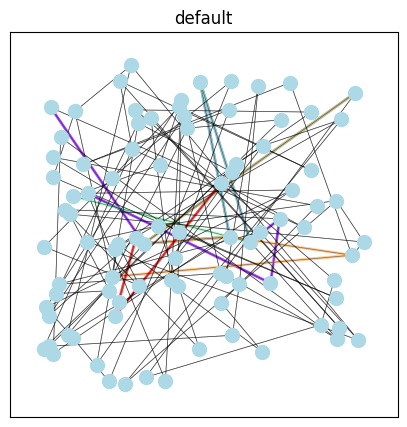

In [11]:
if notebook_mode:
    mode = "test"
    num_data = getattr(config, f'num_{mode}_data')
    batch_size = config.batch_size
    #　DataMakerを繰り返し呼び出しバッチごとにtensorを生成する
    dataset = DatasetReader(num_data, batch_size, mode)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    
    idx = 0
    batch = next(iter(dataset))  # Generate a batch of TSPs
    print("Batch generation took: {:.3f} sec".format(time.time() - t))
    print("edges shape:", batch.edges.shape)
    print("edges:", batch.edges[idx])
    print("edges_capacity shape:", batch.edges_capacity.shape)
    print("edges_capacity:", batch.edges_capacity[idx])
    print("edges_targets shape:", batch.edges_target.shape)
    print("edges_targets:", batch.edges_target[idx, :, :, idx])
    print("nodes shape:", batch.nodes.shape)
    print("nodes:", batch.nodes[idx])
    print("nodes_target shape:", batch.nodes_target.shape)
    print("nodes_target:", batch.nodes_target[idx])
    print("commodities shape:", batch.commodities.shape)
    print("commodities:", batch.commodities[idx])
    print("load_factor shape:", batch.load_factor)
    
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_uelb(a, batch.edges[idx], batch.edges_target[idx])

# Instantiate model

In [12]:
if notebook_mode == True:
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

    # Enable anomaly detection
    torch.autograd.set_detect_anomaly(True)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_embedding): Embedding(30, 64)
    (commodities_embedding): Linear(in_features=1, out_features=64, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=128, bias=False)
    (gcn_layers): ModuleList(
      (0-9): 10 x ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (relu):

# Test forward pass

In [9]:
if notebook_mode == True and viz_mode == False:
    # Generate a batch of UELBs
    mode = "train"
    num_data = getattr(config, f'num_{mode}_data')
    batch_size = config.batch_size
    train_filepath = config.train_filepath
    dataset = iter(DatasetReader(num_data, batch_size, mode))
    batch = next(dataset)

    # Convert batch to torch Variables
    x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
    x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
    x_nodes = torch.LongTensor(batch.nodes).to(torch.long).contiguous().requires_grad_(False)
    y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
    y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
    batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)
    x_commodities = batch_commodities[:, :, 2].to(torch.float)
    
    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = create_edge_class_weights(y_edges)
    print("Class weights: {}".format(edge_cw))
        
    # Enable anomaly detection
    torch.autograd.set_detect_anomaly(True)

    # Forward pass
    y_preds, loss = net.forward(x_edges, x_commodities,x_edges_capacity, x_nodes, y_edges, edge_cw)
    loss = loss.mean()
    print("Output size: {}".format(y_preds.size()))
    #print("Output: {}".format(y_preds[0, :, :, 0]))
    print("Loss value:", loss)

Class weights: tensor([ 0.5038, 66.7656])
Output size: torch.Size([20, 30, 30, 5, 2])
Loss value: tensor(1597.9965, grad_fn=<MeanBackward0>)


# Test backward pass

In [34]:
if notebook_mode == True and viz_mode == False:
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Compute error metrics 
    # err_edges, err_flow, err_uelb, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
    #print("Edge error: {:.3f}\nFlow error: {:.3f}\nUELB error: {:.3f}".format(err_edges, err_flow, err_uelb))
    
    # Compute mean predicted and groundtruth tour length
    y_preds_4d = y_preds[:, :, :, :, 1]
    mean_maximum_load_factor = mean_load_factor(x_edges_capacity, y_preds_4d, x_edges, batch_commodities)
    gt_load_factor = np.mean(batch.load_factor) 
    print("Predicted load factor(Not always a feasible solution): {:.3f}\nGroundtruth load factor: {:.3f}".format(mean_maximum_load_factor, gt_load_factor))

Predicted load factor(Not always a feasible solution): 0.000
Groundtruth load factor: 0.640


# Training Loop (one epoch)

In [13]:
def train_one_epoch(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    mode = "train"
    num_data = getattr(config, f'num_{mode}_data')
    num_commodities = config.num_commodities
    num_nodes = config.num_nodes
    beam_size = config.beam_size
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    
    # Load UELB data
    dataset = DatasetReader(num_data, batch_size, mode)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_err_edges = 0.0
    running_mean_maximum_load_factor = 0.0
    running_gt_load_factor = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
        x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
        x_nodes = torch.LongTensor(batch.nodes).to(torch.long).contiguous().requires_grad_(False)
        y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
        y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
        batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)
        x_commodities = batch_commodities[:, :, 2].to(torch.float)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_commodities, x_edges_capacity, x_nodes, y_edges, edge_cw)
        
        #beam_search = BeamsearchUELB(
        #        y_preds, beam_size, batch_size, x_edges_capacity, batch_commodities, dtypeFloat, dtypeLong, mode_strict=True) 
        #pred_paths = beam_search.search()
        mean_maximum_load_factor = 0 #mean_feasible_load_factor(batch_size, num_commodities, num_nodes, pred_paths, x_edges_capacity, batch_commodities)    
        gt_load_factor = 0 #np.mean(batch.load_factor) 
    

        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()
        
        #print(f"Epoch {epoch+1}")
        for name, param in net.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.norm().item()  # 勾配のL2ノルム
                #print(f"Layer: {name}, Gradient Norm: {grad_norm}")

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean load factor
        err_edges = edge_error(y_preds, y_edges, x_edges)
        #err_edges = edge_error(y_edges, y_edges, x_edges)

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        running_err_edges += batch_size* err_edges
        running_mean_maximum_load_factor += mean_maximum_load_factor
        running_gt_load_factor += gt_load_factor
        running_nb_batch += 1
        
        # Log intermediate statistics
        """
        result = ('loss:{loss:.4f} mean_maximum_load_factor:{mean_maximum_load_factor:.3f} gt_load_factor:{gt_load_factor:.3f}'.format(
            loss=running_loss/running_nb_data,
            mean_maximum_load_factor=running_mean_maximum_load_factor/running_nb_data,
            gt_load_factor=running_gt_load_factor/running_nb_data))
        master_bar.child.comment = result
        """
    # Compute statistics for full epoch
    # 1
    loss = running_loss/ running_nb_data
    err_edges = running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    mean_maximum_load_factor = 0#running_mean_maximum_load_factor/ running_nb_batch
    gt_load_factor = 0#running_gt_load_factor/ running_nb_batch

    return time.time()-start_epoch, loss, err_edges, mean_maximum_load_factor, gt_load_factor


def metrics_for_train(epoch, time, learning_rate, loss, err_edges):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.2f}h\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               'err_edges:{err_edges:.3f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                   err_edges=err_edges
                ))
    return result
    
def metrics_to_str(epoch, time, learning_rate, loss, mean_maximum_load_factor, gt_load_factor, approximation_rate, infeasible_rate):
    result = ( 'epoch:{epoch:0>2d}\t'
               'execution time:{time:.8f}s\t'
               
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               # 'err_edges:{err_edges:.2f}\t'
               # 'err_tour:{err_tour:.2f}\t'
               # 'err_tsp:{err_tsp:.2f}\t'
               'mean_maximum_load_factor:{mean_maximum_load_factor:.3f}\t'
               'gt_load_factor:{gt_load_factor:.3f}\t'
               'approximation_rate:{approximation_rate:.3f}\t'
               'infeasible_rate:{infeasible_rate:.3f}'.format(
                   epoch=epoch,
                   time=time,
                   learning_rate=learning_rate,
                   loss=loss,
                   # err_edges=err_edges,
                   # err_tour=err_tour,
                   # err_tsp=err_tsp,
                   mean_maximum_load_factor=mean_maximum_load_factor,
                   gt_load_factor=gt_load_factor,
                   approximation_rate=approximation_rate,
                   infeasible_rate=infeasible_rate))
    return result

In [17]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        train_time, train_loss, train_err_edges, mean_maximum_load_factor, gt_load_factor = train_one_epoch(net, optimizer, config, epoch_bar)
        epoch_bar.write('t: ' + metrics_for_train(epoch, train_time, learning_rate, train_loss, train_err_edges))

KeyboardInterrupt: 

# Evaluation Loop (for validation and test sets)

In [14]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()
    
    # Assign parameters
    num_data = getattr(config, f'num_{mode}_data')
    batch_size = config.batch_size
    #num_data = 1
    #batch_size = 1
    num_commodities = config.num_commodities
    num_nodes = config.num_nodes
    beam_size = config.beam_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    
    # Load UELB data
    dataset = DatasetReader(num_data, batch_size, mode)
    
        # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_mean_maximum_load_factor = 0.0
    array_mean_maximum_load_factor = []
    running_gt_load_factor = 0.0
    array_gt_load_factor = []
    running_nb_data = 0
    running_nb_batch = 0
    feasible_count = 0
    infeasible_count = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
            x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
            x_nodes = torch.LongTensor(batch.nodes).to(torch.long).contiguous().requires_grad_(False)
            y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
            y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
            batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)
            x_commodities = batch_commodities[:, :, 2].to(torch.float)

            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
                

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_commodities, x_edges_capacity, x_nodes, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs
            torch.set_printoptions(linewidth=200)
            
                
            beam_search = BeamsearchUELB(
                y_preds, beam_size, batch_size, x_edges_capacity, batch_commodities, dtypeFloat, dtypeLong, mode_strict=True) 
            #bs_nodes, pred_paths = beam_search.search()
            pred_paths, is_feasible = beam_search.search()
            #print("pred_paths: ", pred_paths)
            
            #if batch_num == 0:
                #print("bs_nodes.shape: ", bs_nodes.shape)
                #print("bs_nodes:\n", bs_nodes)
                #print("pred_paths:\n", pred_paths)
            
            # Compute error metrics and mean load factor
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds_4d, y_edges, x_edges)

            mean_maximum_load_factor, maximum_load_factors = mean_feasible_load_factor(batch_size, num_commodities, num_nodes, pred_paths, x_edges_capacity, batch_commodities)

            if mean_maximum_load_factor > 1:
                mean_maximum_load_factor = 0
                gt_load_factor = 0
                infeasible_count += 1
            else:
                feasible_count += 1
                gt_load_factor = np.mean(batch.load_factor)
                 

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
            running_mean_maximum_load_factor += mean_maximum_load_factor
            running_gt_load_factor += gt_load_factor
            running_nb_batch += 1
            array_mean_maximum_load_factor.append(maximum_load_factors.tolist())
            array_gt_load_factor.append(batch.load_factor.tolist())
            # print("maximum_load_factors: ", maximum_load_factors.tolist().shape)
            # print("batch.load_factor: ", batch.load_factor.tolist().shape)
        
            # Log intermediate statistics
            result = ('loss:{loss:.4f} mean_maximum_load_factor:{mean_maximum_load_factor:.3f} gt_load_factor:{gt_load_factor:.3f}'.format(
                loss=running_loss/running_nb_data,
                mean_maximum_load_factor=running_mean_maximum_load_factor/running_nb_batch,
                gt_load_factor=running_gt_load_factor/running_nb_batch))
            master_bar.child.comment = result
            
    # Compute statistics for full epoch
    # 2
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    infeasible_rate = infeasible_count / (feasible_count + infeasible_count) * 100
    if feasible_count != 0:
        mean_gt_load_factor = running_gt_load_factor/ feasible_count
        epoch_mean_maximum_load_factor = running_mean_maximum_load_factor/ feasible_count      
        approximation_rate = mean_gt_load_factor / epoch_mean_maximum_load_factor * 100
    else:
        mean_gt_load_factor = 0
        epoch_mean_maximum_load_factor = 0
        approximation_rate = 0

    # print("mode: ", mode)
    # #nomalized_y_preds_0 = show_nomalized_edge(y_preds[:, :, :, :, 0])
    # #nomalized_y_preds_1 = show_nomalized_edge(y_preds[:, :, :, :, 1])
    # print("y_edges:\n", y_edges[0, :, :, 0])
    # print("x_edges:\n", x_edges[0, :, :])
    # y = F.log_softmax(y_preds, dim=4)  # B x V x V x C x voc_edges
    # #print("y_preds[:, :, :, :, 0]:\n", nomalized_y_preds_0[0, :, :, 0])
    # #print("y_preds[:, :, :, :, 1]:\n", nomalized_y_preds_1[0, :, :, 0])
    # print("y_preds[0, :, :, 0, 1]:\n", y_preds[0, :, :, 0, 1])
    # print("y[0, :, :, 0, 1]:\n", y[0, :, :, 0 ,1])
        
    return time.time()-start_test, loss, err_edges, epoch_mean_maximum_load_factor, mean_gt_load_factor, approximation_rate, infeasible_rate, array_mean_maximum_load_factor, array_gt_load_factor


In [128]:

if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        # Validation
        val_time, val_loss, val_err_edges, val_mean_maximum_load_factor, val_gt_load_factor, val_approximation_rate, val_infeasible_rate, array_mean_maximum_load_factor, array_gt_load_factor = test(net, config, epoch_bar, mode='val')
        epoch_bar.write('v: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_mean_maximum_load_factor, val_gt_load_factor, val_approximation_rate, val_infeasible_rate))

        # Testing
        test_time, test_loss, test_err_edges, test_mean_maximum_load_factor, test_gt_load_factor, test_approximation_rate, test_infeasible_rate, array_mean_maximum_load_factor, array_gt_load_factor = test(net, config, epoch_bar, mode='test')
        epoch_bar.write('T: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, val_mean_maximum_load_factor, test_gt_load_factor, test_approximation_rate, test_infeasible_rate))

# Run full training pipeline 

In [15]:
def plot_training_metrics(train_loss, train_err_edges, val_approx_rate, test_approx_rate):
    """
    Plot training loss, edge errors, and approximation rates over epochs.
    """
    epochs = range(len(train_loss))
    
        # Plot Training Loss
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.show()

    # Plot Edge Errors
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_err_edges, label="Edge Errors (Train)", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Edge Error")
    plt.title("Training Edge Error over Epochs")
    plt.legend()
    plt.show()

    # Plot Approximation Rate for Validation and Test
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(val_approx_rate)), val_approx_rate, label="Approximation Rate (Validation)", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Approximation Rate")
    plt.title("Validation Approximation Rate over Epochs")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(range(len(test_approx_rate)), test_approx_rate, label="Approximation Rate (Test)", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Approximation Rate")
    plt.title("Test Approximation Rate over Epochs")
    plt.legend()
    plt.show()
    
def plot_test_result(array_mean_maximum_load_factor, array_gt_load_factor):
    # 平坦化（フラット化）してデータを準備
    mean_maximum_load_flat = [item for sublist in array_mean_maximum_load_factor for item in sublist]
    gt_load_flat = [item for sublist in array_gt_load_factor for item in sublist]
    
    
    # Approximation rate の計算
    approximation_rates = [gt / mean for gt, mean in zip(gt_load_flat, mean_maximum_load_flat)]

    # 第一四分位数の計算
    first_quartile = np.percentile(approximation_rates, 25)

    print("First Quartile of Approximation rate:", first_quartile)

    # プロット
    plt.figure(figsize=(10, 6))
    plt.plot(mean_maximum_load_flat, label="Mean Maximum Load Factor", color="blue", marker='o')
    plt.plot(gt_load_flat, label="Ground Truth Load Factor", color="orange", marker='x')
    plt.ylim(0, 1)

    # グラフの装飾
    plt.title("Comparison of Mean Maximum Load Factor and Ground Truth Load Factor")
    plt.xlabel("Data Index")
    plt.ylabel("Load Factor")
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
import matplotlib.pyplot as plt

def main(config):
    # Instantiate the network
    config_path = "configs/default2.json"
    config = get_config(config_path)
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = sum(np.prod(list(param.data.size())) for param in net.parameters())
    print('Number of parameters:', nb_param)

    # Create log directory
    log_dir = f"./logs/{config.expt_name}/"
    os.makedirs(log_dir, exist_ok=True)
    json.dump(config, open(f"{log_dir}/config.json", "w"), indent=4)
    writer = SummaryWriter(log_dir)  # Tensorboard writer

    # Training parameters
    max_epochs = config.max_epochs
    val_every = config.val_every
    test_every = config.test_every
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate
    val_loss_old = 1e6  # For decaying LR based on validation loss
    
    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    print(optimizer)

    # Initialize variables for logging
    train_loss_list = []
    train_err_edges_list = []
    val_approximation_rate_list = []
    test_approximation_rate_list = []

    epoch_bar = master_bar(range(max_epochs))
    for epoch in epoch_bar:
        writer.add_scalar('learning_rate', learning_rate, epoch)
        
        # Train
        train_time, train_loss, train_err_edges, mean_maximum_load_factor, gt_load_factor = train_one_epoch(net, optimizer, config, epoch_bar)
        train_loss_list.append(train_loss)
        train_err_edges_list.append(train_err_edges)
        epoch_bar.write('t: ' + metrics_for_train(epoch, train_time, learning_rate, train_loss, train_err_edges))

        if epoch % val_every == 0 or epoch == max_epochs - 1:
            # Validation
            print("epoch: ", epoch)
            val_time, val_loss, val_err_edges, val_mean_maximum_load_factor, val_gt_load_factor, val_approximation_rate, val_infeasible_rate, array_mean_maximum_load_factor, array_gt_load_factor = test(net, config, epoch_bar, mode='val')
                    
            val_approximation_rate_list.append(val_approximation_rate)
            epoch_bar.write('v: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_mean_maximum_load_factor, val_gt_load_factor, val_approximation_rate, val_infeasible_rate))
            
        if epoch % val_every == 0 and epoch != 0:
            # Update learning rate
            #if val_loss > 0.99 * val_loss_old:
            learning_rate /= decay_rate
            optimizer = update_learning_rate(optimizer, learning_rate)
            val_loss_old = val_loss

        if epoch % test_every == 0 or epoch == max_epochs - 1:
            # Test
            print("epoch: ", epoch)
            test_time, test_loss, test_err_edges, test_mean_maximum_load_factor, test_gt_load_factor, test_approximation_rate, test_infeasible_rate, array_mean_maximum_load_factor, array_gt_load_factor = test(net, config, epoch_bar, mode='test')
            test_approximation_rate_list.append(test_approximation_rate)
            epoch_bar.write('T: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_mean_maximum_load_factor, test_gt_load_factor, test_approximation_rate, test_infeasible_rate))
            plot_test_result(array_mean_maximum_load_factor, array_gt_load_factor)
        
    # Plot training metrics after the training loop
    plot_training_metrics(train_loss_list, train_err_edges_list, val_approximation_rate_list, test_approximation_rate_list)

    return net


DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_embedding): Embedding(30, 64)
    (commodities_embedding): Linear(in_features=1, out_features=64, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=128, bias=False)
    (gcn_layers): ModuleList(
      (0-9): 10 x ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (relu):

epoch:  0
epoch:  0
First Quartile of Approximation rate: 0.400452270357784


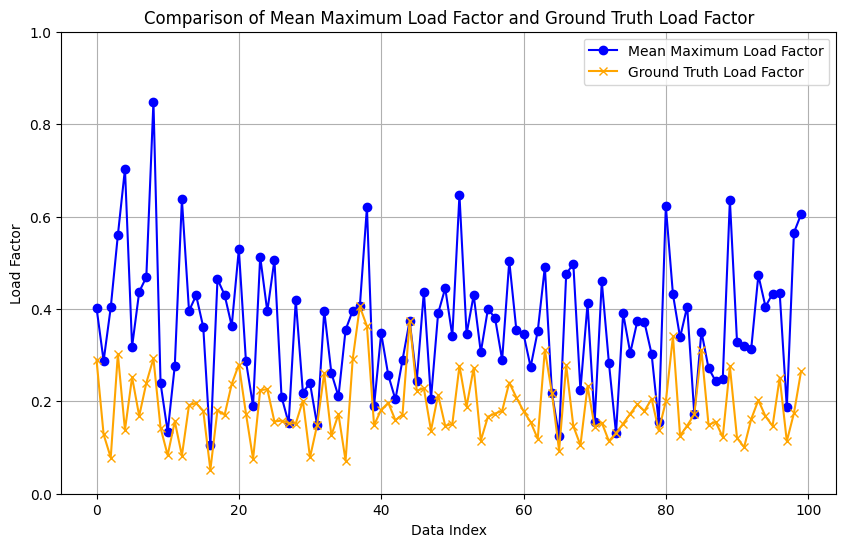

epoch:  3
epoch:  3
First Quartile of Approximation rate: 0.41088675585308493


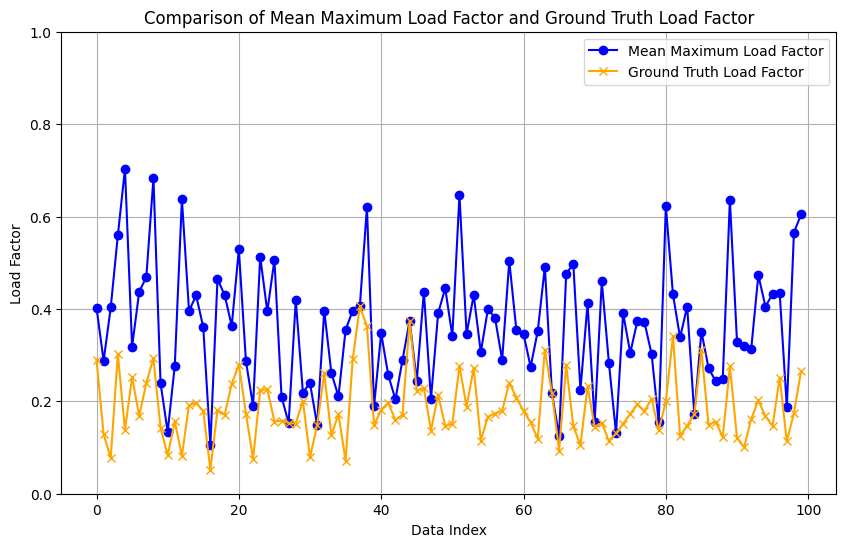

In [17]:
if viz_mode==False:
    # del net
    net = main(config)
    